## Final Project Submission

* Student name: Kai Cansler
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


# *King County Housing Analysis by Area*
***
## Overview
For the analysis we will be using data from house sales in King County Washington. Our analysis is to predict home prices by area to identify undervalued and overvalued properties in zipcodes. Our model will tell us the average information on homes in a given area and compare how properties fit and valued in those areas. 
***

### Business and Data Understanding
Our Data contains information of home sales in kings county kc_house_data.csv. The data has a mixture of numerical and categorical data. It contains 8 object, 5 float, and 10 integer types of features. The data contains 30,155 observations of housing data. We dropped 44 observations that had missing value for a total of 30,111 observations. 

As the data extends only about a year of home sales we will not utilize a time series analysis and focus more on linear regression. The dataset includes features such as, lat, lon that will be used to reverse geocode ZIP code information. We want to use these features to understand the average price of ZIP codes and understand average home in each area to understand what ZIP code we would like to purchase our property in. We will also use our model to price homes within those ZIP codes to find undervalued properties.
<br>
***
### Stakeholders
The stakeholder for this project are investors who are looking for undervalued properties that would be great options for their investments. We are looking to generate profit by finding alpha (the difference between estimated value and real value). These homebuyers are investors looking to diversify their portfolio with real estate investment, Home buyers who are looking for a great deal for long term investment, and real estate investors looking to find arbitrage opportunities. The aim is to show what zip codes are undervalued in different zipcodes within Kings County as well as taking a look at how some of these zipcodes compare with each other. Our shareholders are looking for how the specific homes compare with the average home in different zipcodes related to square footage, condition, grade, and other features to find undervalued properties.
***

### Import our Libraries
We want to introduce pandas and numpy for preprocessing and managing our dataframe. We will also utilise statsmodels and scipy.stats to complete statistical analysis and build our model. Lastly we will use seaborn and matplotlib for our visualizations.

In [1]:
# We want to begin our modeling by loading all our tools
# import our tools for preprocessing and model building
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

# import visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# We will be using style 'ggplot' for our visualizations
plt.style.use('ggplot')

In [2]:
# Load dataset into DataFrame object
df = pd.read_csv('data/kc_house_data.csv')
# Take a look at the overview of our data
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7399300360   5/24/2022  675000.0         4        1.0         1180   
1  8910500230  12/13/2021  920000.0         5        2.5         2770   
2  1180000275   9/29/2021  311000.0         6        2.0         2880   
3  1604601802  12/14/2021  775000.0         3        3.0         2160   
4  8562780790   8/24/2021  592500.0         2        2.0         1120   

   sqft_lot  floors waterfront greenbelt  ... sewer_system sqft_above  \
0      7140     1.0         NO        NO  ...       PUBLIC       1180   
1      6703     1.0         NO        NO  ...       PUBLIC       1570   
2      6156     1.0         NO        NO  ...       PUBLIC       1580   
3      1400     2.0         NO        NO  ...       PUBLIC       1090   
4       758     2.0         NO        NO  ...       PUBLIC       1120   

  sqft_basement sqft_garage sqft_patio yr_built  yr_renovated  \
0             0           0         40     1969             0   
1          1570           0        240     1950             0   
2          1580           0          0     1956             0   
3          1070         200        270     2010             0   
4           550         550         30     2012             0   

                                             address        lat       long  
0  2102 Southeast 21st Court, Renton, Washington ...  47.461975 -122.19052  
1  11231 Greenwood Avenue North, Seattle, Washing...  47.711525 -122.35591  
2  8504 South 113th Street, Seattle, Washington 9...  47.502045 -122.22520  
3  4079 Letitia Avenue South, Seattle, Washington...  47.566110 -122.29020  
4  2193 Northwest Talus Drive, Issaquah, Washingt...  47.532470 -122.07188  

[5 rows x 25 columns]

In [3]:
# See if we can take zipcode info from the address
print(df['address'].head())

0    2102 Southeast 21st Court, Renton, Washington ...
1    11231 Greenwood Avenue North, Seattle, Washing...
2    8504 South 113th Street, Seattle, Washington 9...
3    4079 Letitia Avenue South, Seattle, Washington...
4    2193 Northwest Talus Drive, Issaquah, Washingt...
Name: address, dtype: object


The strings are shortened to a maximum amount of characters making it so we are missing zip code information. We will have to use the latitude and longitude columns in our dataframe to reverse geocode zip code. Area is an important factor when choosing property and should be a feature that is important for our model.

### Explore our data
We want to do some exploratory analysis of our features.

1. Clean the data and make our features easier to manage

    We want to convert grade, condition, and view to an ordinal categorical feature containing integer data. Turn waterfront to a boolean integer data type.

In [4]:
# Lets turn date column to datetime from object
df['date'] = pd.to_datetime(df['date'])

# Grade column contains string but can be stack ranked numerically
df['grade'] = df.grade.str.split(" ", 1).str[0].astype(int) - 1

In [5]:
# Turn "condition" to ordinal numerical feature
# This is to assess linearity assumption for our model
df.waterfront.replace({'NO': 0, 'YES': 1}, inplace=True)
df.condition.replace({'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}, inplace=True)
df.view.replace({'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4 }, inplace=True)

In [6]:
# Remove homes that are not up to minimum building standards
df = df[df['grade'] > 3]

# Index it 0 to make it interpretable for our model.
df.grade.replace({4:0, 5:1, 6:2, 7:3, 8:4, 9:5, 10:6, 11:7, 12:8, 13:9}, inplace=True)

We are indexing everything to 0 to make our intercept coefficient more interpretable.

Lastly we will remove any observations with missing data as the number of observations with missing data is low.

In [7]:
# Resolve missing data in heat_source and sewer_system
df = df.dropna()

2. Finding Zipcodes

Zipcodes is not within our data set so we will have to use Latitude and Longitude info to reverse geocode and obtain zipcodes for each observation. 

For this we will be utilizing geopandas and shapely to create points using our latitude and longitude data and joining it with zipcode data.
    The zipcode shapefile taken from arcgis open source data. https://gis-kingcounty.opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6/explore

In [8]:
# Install geopandas and shapely packages using pip
# Use of '-q' quiet to hide output
!pip install geopandas -q
!pip install fiona shapely pyproj -q

In [9]:
# https://stackoverflow.com/questions/71286742/use-python-to-covert-400-000-latitude-longitudes-to-zip-code
# Import geopandas and shapely and use them to create our points Geopandas DataFrame
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

In [10]:
# Create ZIP codes GeoDataFrame
zip_codes = gpd.read_file('data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp')

In [11]:
# Join ZIP codes to the point GeoDataFrame
result = gpd.sjoin(gdf, zip_codes, how='left', predicate='intersects')

In [12]:
result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 30055 entries, 0 to 30154
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30055 non-null  int64         
 1   date           30055 non-null  datetime64[ns]
 2   price          30055 non-null  float64       
 3   bedrooms       30055 non-null  int64         
 4   bathrooms      30055 non-null  float64       
 5   sqft_living    30055 non-null  int64         
 6   sqft_lot       30055 non-null  int64         
 7   floors         30055 non-null  float64       
 8   waterfront     30055 non-null  int64         
 9   greenbelt      30055 non-null  object        
 10  nuisance       30055 non-null  object        
 11  view           30055 non-null  int64         
 12  condition      30055 non-null  int64         
 13  grade          30055 non-null  int64         
 14  heat_source    30055 non-null  object        
 15  sewer_syste

3. Understand our Dataset
    
    Take a look at visualizations of our features to see that our data fits the assumptions for linear regression.

<AxesSubplot:xlabel='condition', ylabel='price'>

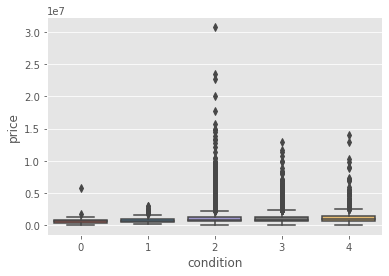

In [13]:
sns.boxplot(x='condition', y='price', data=result)

<AxesSubplot:xlabel='grade', ylabel='price'>

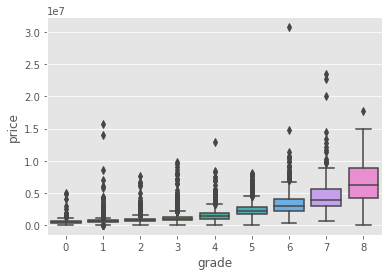

In [14]:
sns.boxplot(x='grade', y='price', data=result)

We will remove the outliers in price that could effect our model.

In [15]:
zscores = np.abs(stats.zscore(result['price']))
result_no_outliers = result[(zscores < 3)]

We will remove and keep only the features that relate to our model.

- 'id' is a unique identifier without any useful information.
- 'address' does not give us important information as we are focusing on ZIP for location information.
- 'lat', 'long' as we have already derived ZIP from the reverse geocoding and is no longer necessary.
- 'date' as the sale date wouldn't provide much information as it ranges only a year.
- 'yr_built', 'yr_renovated' 
- 'sqft_lot' as there are many apartments from the inner city.
- Keep only 'ZIPCODE' from the reverse geocoding columns

In [16]:
# DataFrame of our target features
df_target = result_no_outliers[['price', 'sqft_living', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'sqft_above',
                    'waterfront', 'condition', 'grade', 'floors', 'bedrooms', 'bathrooms', 'view', 'ZIPCODE']].copy()
# 'greenbelt', 'heat_source', 'sewer_system', 'sqft_lot', 'floors', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built', 'waterfront', 

### Check Numerical data for Multicollinearity
Our first approach will be to understand the correlation of our numerical features. We will use a correlation matrix for this.

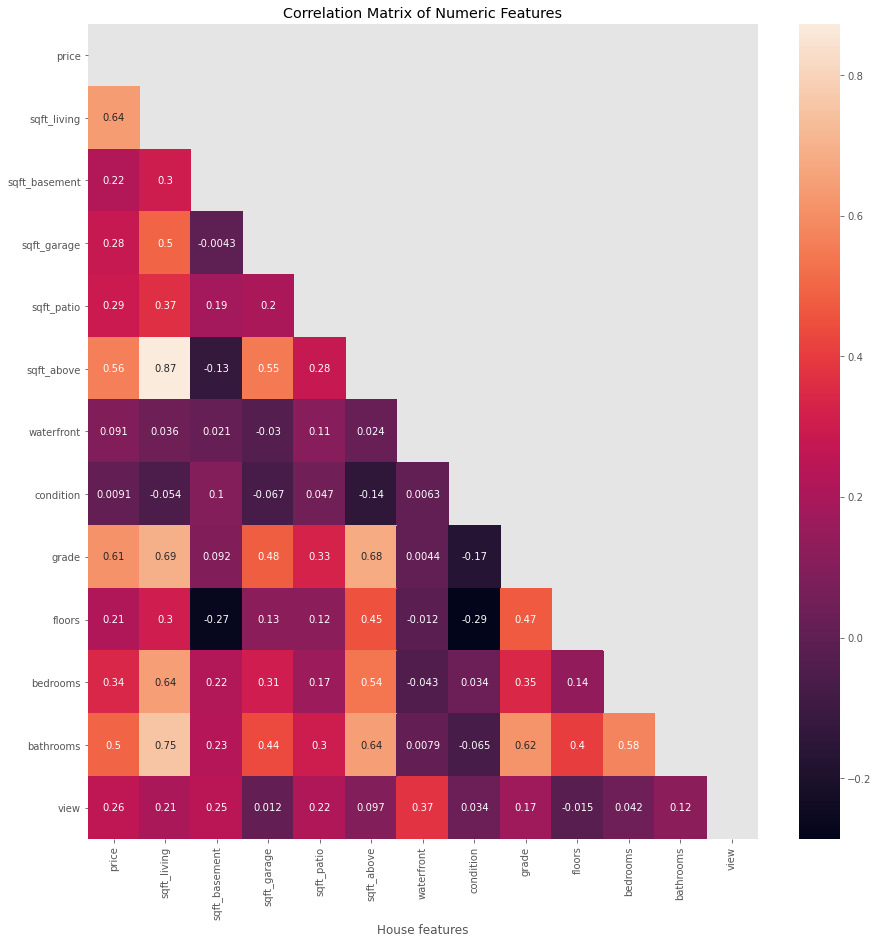

In [17]:
# Separate our useful numerical data for analysis
df_num = df_target.select_dtypes(include=[np.number])

# Correlation Matrix without duplicates
corr_matrix = df_num.corr()
matrix = np.triu(corr_matrix)

# Use seaborn heatmap to plot the correlation matrix
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr_matrix, annot=True, mask=matrix)

# Label the plot
plt.title('Correlation Matrix of Numeric Features')
plt.xlabel('House features')
plt.xticks(size=10)
plt.yticks(size=10);

In [18]:
# Take our correlation matrix and take the absolute value and pivot to create a pairs of features
corr_df=corr_matrix.abs().stack().reset_index().sort_values(0, ascending=False)

# Zip the variable name columns into a column named pairs
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# Set index to pairs
corr_df.set_index(['pairs'], inplace = True)

# Drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# Rename correlation column as cc rather than 0
corr_df.columns = ['corr_coeff']

# Drop duplicates for legibility.
corr_df.drop_duplicates(inplace=True)

In [19]:
corr_df[(corr_df.corr_coeff>.70) & (corr_df.corr_coeff<1)]

corr_coeff
pairs                                
(sqft_above, sqft_living)    0.873038
(sqft_living, bathrooms)     0.751185

There are alot of feature pairs with high correlation.
1. The variables of focus are sqft_living, sqft_above, bathrooms, long, and lat. 
2. These have a high risk for multicollinearity so we will choose one feature for our model.
3. latitude and longitude will be used to create ZIP code and can be removed

We will be choosing sqft_living as it had the highest correlation with price.

In [20]:
df_target = df_target.drop(['sqft_above', 'bathrooms'], axis=1)

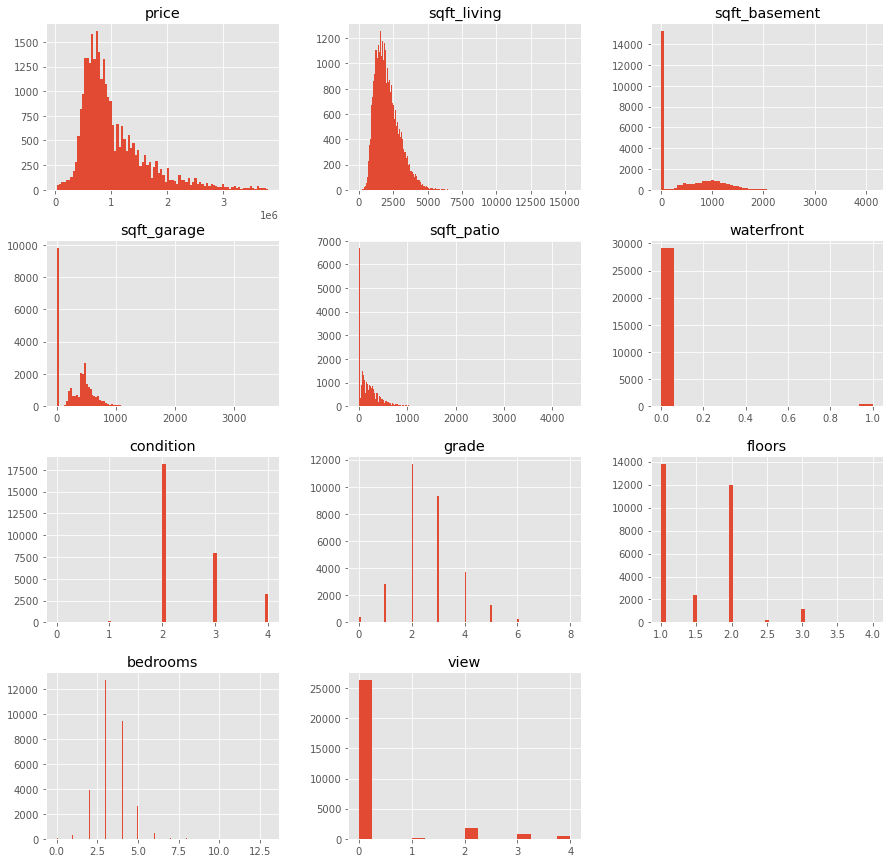

In [21]:
# View the distribution of our variables for normality
df_target.hist(figsize=(15,15), bins='auto');

### Creating Baseline Linear Regression Model

Now that the data is cleaned we can check the results of our linear regression model.

In [22]:
# Our first baseline model with just sqft_living to price
y_baseline = df_target['price']
X_baseline = df_target[['sqft_living']]

In [23]:
# Linear Regression and fit the model
baseline_model = sm.OLS(y_baseline, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 2.040e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:56   Log-Likelihood:            -4.2826e+05
No. Observations:               29620   AIC:                         8.565e+05
Df Residuals:                   29618   BIC:                         8.565e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.565e+05   6738.357     23.227      

Result
- The model explains about 40.8% of the variance in our data.
- The Prob F-statistic is less than alpha of 0.05 and statistically significant
- sqft_living is statistically significant with a p-value less than alpha of 0.05

Interpretation:
- For each additional 1 square foot in living space size we would expect the house to gain about $425
***

The correlation coefficient for condition was exteremely low as seen in our correlation matrix. Before we jump into creating our first multi-regression model we will test the effect of condition on our model. 

In [24]:
# Test addition of condition feature
y_condition = df_target['price']
X_condition = df_target[['sqft_living', 'condition']]

# Linear Regression and fit the model
condition_model = sm.OLS(y_condition, sm.add_constant(X_condition)).fit()

print(condition_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                 1.028e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:56   Log-Likelihood:            -4.2821e+05
No. Observations:               29620   AIC:                         8.564e+05
Df Residuals:                   29617   BIC:                         8.565e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.086e+04   1.19e+04      5.131      

As we suspected with conditions correlation to price was extremely low and did not have an effect on the Adj. R-squared (.002) and does not provide any benefit to our model. We will remove condition from our predictor variables.

In [25]:
df_target = df_target.drop(['condition'], axis=1)

### Creating Multi-linear Regression Model.

Our model of only sqft_living to price is not an effective model to explain the variance in our data. We will incorporate all our clean features without high correlation coefficients.

In [26]:
# Setup our second model with all our target features
y = df_target['price']
X_model2 = df_target.drop(['price'], axis=1)
X_model2 = pd.get_dummies(X_model2, columns=['ZIPCODE'], drop_first=True)

In [27]:
formula_model2 = sm.OLS(y, sm.add_constant(X_model2))
model2 = formula_model2.fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     793.0
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:56   Log-Likelihood:            -4.1725e+05
No. Observations:               29620   AIC:                         8.347e+05
Df Residuals:                   29524   BIC:                         8.355e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.153e+05   1.26e+04      9.188

Result:

- The model explains about 71.8% of the variance in our data.
- The Prob F-statistic is not less than alpha of 0.05 and is not statistically significant.

Interpretations:

- The coefficient means that with all variables held at 0 the house would have a price of \$115\,300.00.
- For every 1 square ft increase in sqft_living all else held at 0 the house price is expected to increase by $290\.69.
- For every 1 square ft increase in sqft_basement alll else held at 0 the house price is expected to decrease by \$68\.43.
- For every 1 square ft increase in sqft_garage all else held at 0 the house price is expected to decrease by \$12.49.
- For every 1 square ft increase in sqft_patio all else held at 0 the house price is expected to increase by \$60.27.
- If waterfront is true holding all else held at 0 the house price is expected to increase \$285,700.00.
- For every 1 point increase in grade all else held  at 0 the house pricee is expected to increase \$110,200.00.
- For every 1 unit increase in floors all else held at 0 the house price is expected to decrease \$55,240.00.
- For every 1 unit increase in view holding all else at 0 the house price is expected to increase \$75,750.00.
***

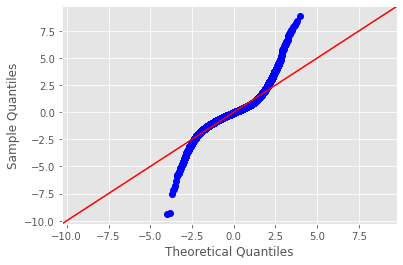

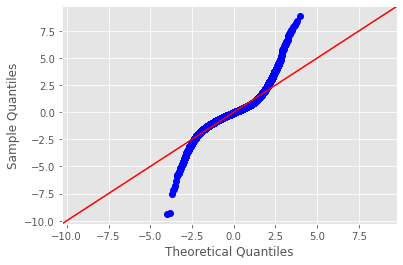

In [28]:
# take our residuals to check for normality
resids = model2.resid
sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)

***
Our model fails the normality assumption. To resolve this issue we will look to transform our data. From our distribution visualization above we see that price and sqft_living have a large right skew. We will use a log transformation to ensure our normality assumptiosn are not violated.

### Log transform our numerical features.

Test to see how log transforming our data will effect kurtotis and skew to see if it will be beneficial in normalizing our target and predictor features.

In [29]:
print("Skew of raw price data: %f" % df_target['price'].skew()) #check skewness
print("Kurtosis of raw price data: %f" % stats.kurtosis(df_target['price'],fisher = False)) #check kurtosis
print('')
print("Skew of raw sqft_living data: %f" % df_target['sqft_living'].skew()) #check skewness
print("Kurtosis of raw sqft_living price data: %f" % stats.kurtosis(df_target['sqft_living'],fisher = False)) #check kurtosis
print('')
print("Skew of raw sqft_basement data: %f" % df_target['sqft_basement'].skew()) #check skewness
print("Kurtosis of raw sqft_basement price data: %f" % stats.kurtosis(df_target['sqft_basement'],fisher = False)) #check kurtosis
print('')
print("Skew of raw sqft_garage data: %f" % df_target['sqft_garage'].skew()) #check skewness
print("Kurtosis of raw sqft_garage price data: %f" % stats.kurtosis(df_target['sqft_garage'],fisher = False)) #check kurtosis
print('')
print("Skew of raw sqft_patio data: %f" % df_target['sqft_patio'].skew()) #check skewness
print("Kurtosis of raw sqft_patio price data: %f" % stats.kurtosis(df_target['sqft_patio'],fisher = False)) #check kurtosis

Skew of raw price data: 1.625421
Kurtosis of raw price data: 6.017808

Skew of raw sqft_living data: 1.230153
Kurtosis of raw sqft_living price data: 7.437456

Skew of raw sqft_basement data: 0.887834
Kurtosis of raw sqft_basement price data: 3.037055

Skew of raw sqft_garage data: 0.567608
Kurtosis of raw sqft_garage price data: 4.467097

Skew of raw sqft_patio data: 2.278728
Kurtosis of raw sqft_patio price data: 14.605325


In [30]:
df_log = df_target.copy()
for col in ['price', 'sqft_living', 'sqft_basement', 'sqft_garage', 'sqft_patio']:
    df_log[f'log_{col}'] = np.log(df_target[col])

df_log

/Users/kaicansler/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


price  sqft_living  sqft_basement  sqft_garage  sqft_patio  \
0       675000.0         1180              0            0          40   
1       920000.0         2770           1570            0         240   
2       311000.0         2880           1580            0           0   
3       775000.0         2160           1070          200         270   
4       592500.0         1120            550          550          30   
...          ...          ...            ...          ...         ...   
30150  1555000.0         1910           1130            0         210   
30151  1313000.0         2020              0            0         520   
30152   800000.0         1620            920          240         110   
30153   775000.0         2570            740          480         100   
30154   500000.0         1200              0          420           0   

       waterfront  grade  floors  bedrooms  view ZIPCODE  log_price  \
0               0      2     1.0         4     0   98055  13.422468   
1               0      2     1.0         5     2   98133  13.732129   
2               0      2     1.0         6     2   98178  12.647548   
3               0      4     2.0         3     2   98118  13.560618   
4               0      2     2.0         2     0   98027  13.292106   
...           ...    ...     ...       ...   ...     ...        ...   
30150           0      3     1.5         5     0   98103  14.256986   
30151           0      2     2.0         3     1   98116  14.087825   
30152           0      2     1.0         3     0   98122  13.592367   
30153           0      3     2.0         3     0   98055  13.560618   
30154           0      2     1.0         3     0   98148  13.122363   

       log_sqft_living  log_sqft_basement  log_sqft_garage  log_sqft_patio  
0             7.073270               -inf             -inf        3.688879  
1             7.926603           7.358831             -inf        5.480639  
2             7.965546           7.365180             -inf            -inf  
3             7.677864           6.975414         5.298317        5.598422  
4             7.021084           6.309918         6.309918        3.401197  
...                ...                ...              ...             ...  
30150         7.554859           7.029973             -inf        5.347108  
30151         7.610853               -inf             -inf        6.253829  
30152         7.390181           6.824374         5.480639        4.700480  
30153         7.851661           6.606650         6.173786        4.605170  
30154         7.090077               -inf         6.040255            -inf  

[29620 rows x 16 columns]

The log transformation of sqft_basement, sqft_garage, and sqft_patio resulted in -inf values because of the large volume of missing values. We will not continue with the log transformation of these features.

In [31]:
for col in ['price', 'sqft_living']:
    df_target[f'log_{col}'] = np.log(df_target[col])

In [32]:
# https://stackoverflow.com/questions/69059121/how-to-draw-a-normal-curve-on-seaborn-displot
# Define function map_pdf to map normal distribution because new displot does not contain normal dist mapping like distplot
def map_pdf(x, **kwargs):
    mu, std = stats.norm.fit(x)
    x0, x1 = plot.axes[0][0].get_xlim()  # axes for p1 is required to determine x_pdf
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.norm.pdf(x_pdf, mu, std)
    plt.plot(x_pdf, y_pdf, c='b')

Skew after Log Transformation: -0.286048
Kurtosis after Log Transformation: 5.091130


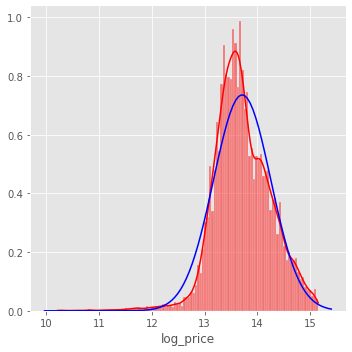

In [33]:
plot = sns.displot(df_target['log_price'], kde=True, color ="r", stat='density')
plot.map(map_pdf, 'log_price')
print("Skew after Log Transformation: %f" % df_target['log_price'].skew())
print("Kurtosis after Log Transformation: %f" % stats.kurtosis(df_target['log_price'],fisher = False))

Skew after Log Transformation: -0.228680
Kurtosis after Log Transformation: 4.559367


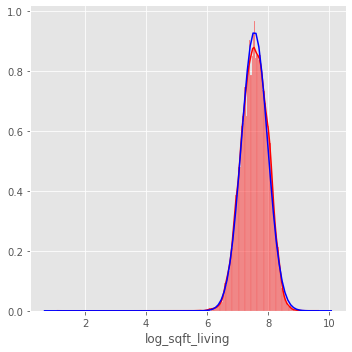

In [34]:
plot = sns.displot(df_target['log_sqft_living'], kde=True, color ="r", stat='density')
plot.map(map_pdf, 'log_sqft_living')
print("Skew after Log Transformation: %f" % df_target['log_sqft_living'].skew())
print("Kurtosis after Log Transformation: %f" % stats.kurtosis(df_target['log_sqft_living'],fisher = False))

Many of the predictor variables that were log transformed resulted in many 'inf' values from the log transformation of 0 values. We will not log transform the predictor variables.

### Multi-linear Regression Model with Normalized target

We will now view the reuslts of our multi-lienar regression with normalized sqft_living and price features. ZIPCODE will be added to this model. We will dummy encode ZIPCODE as it is not an ordinal categorical variable.

In [35]:
y = df_target['log_price']
X_model3_pre = df_target.drop(['log_price', 'price', 'log_sqft_living'], axis=1)
X_model3 = pd.get_dummies(X_model3_pre, columns=['ZIPCODE'], drop_first=True)
model3 = sm.OLS(y, sm.add_constant(X_model3)).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     595.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:58   Log-Likelihood:                -8039.9
No. Observations:               29620   AIC:                         1.627e+04
Df Residuals:                   29524   BIC:                         1.707e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8309      0.013   1021.780

Result
- The model explains about 65.6% of the variance in our data.
- The F-statistic is high leading to a near 0 Prob F-statistic which can indicate
- sqft_living is statistically significant with a p-value less than alpha of 0.05
***

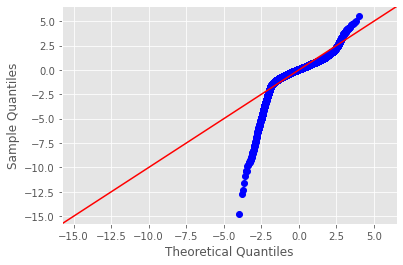

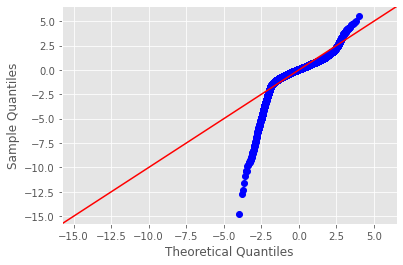

In [36]:
resids = model3.resid
sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)

In [57]:
df_target = df_target.drop(['log_sqft_living'], axis=1)

### Group by ZIP code
To better understand the differences in average housing for each area we will group by ZIP Code and create a model to see if there is a linear relationship.

In [38]:
# Reset df because groupby will take the average and the already removed outliers can cause bias in our model. 
df_features = result[['price', 'sqft_living', 'grade', 'bedrooms', 'floors',
                    'view', 'ZIPCODE', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'waterfront']].copy()
df_zip = df_features.groupby(by=['ZIPCODE']).mean()
df_zip = df_zip.reset_index()
df_zip.head()

df_zip['log_price'] = np.log(df_zip['price'])
df_zip['log_sqft_living'] = np.log(df_zip['sqft_living'])

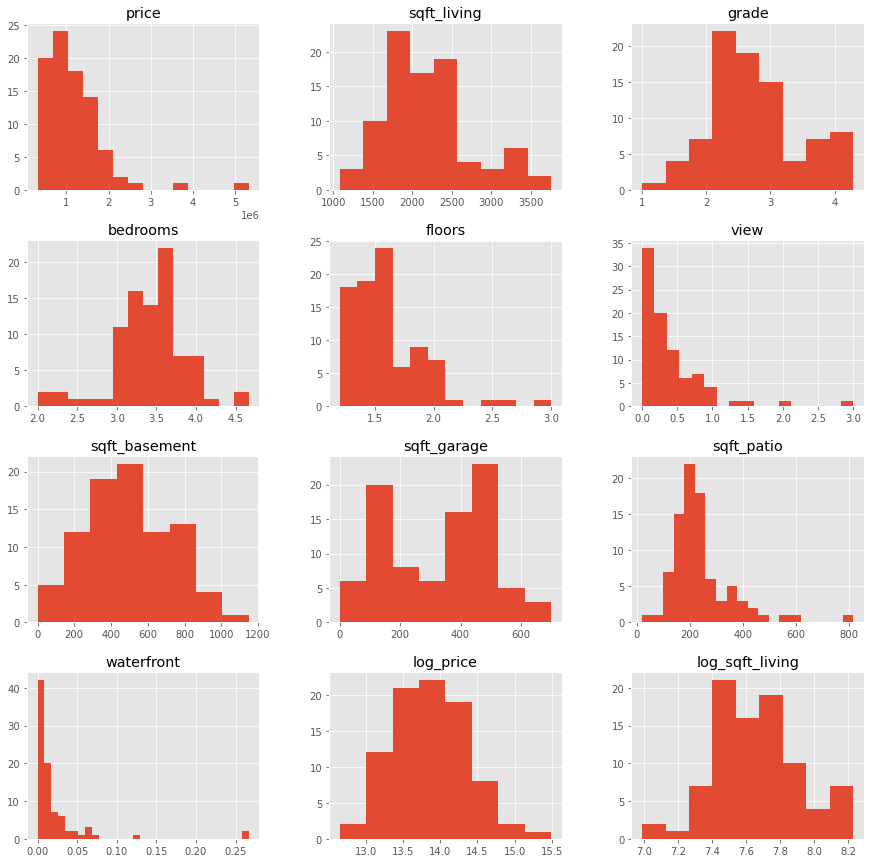

In [39]:
df_zip.hist(figsize=(15,15), bins='auto');

In [40]:
print("Skew of raw price data: %f" % df_zip['price'].skew()) #check skewness
print("Kurtosis of raw price data: %f" % stats.kurtosis(df_zip['price'],fisher = False)) #check kurtosis
print('')
print("Skew of raw sqft_living data: %f" % df_zip['sqft_living'].skew()) #check skewness
print("Kurtosis of raw sqft_living price data: %f" % stats.kurtosis(df_zip['sqft_living'],fisher = False)) #check kurtosis

Skew of raw price data: 2.906746
Kurtosis of raw price data: 15.315373

Skew of raw sqft_living data: 0.794037
Kurtosis of raw sqft_living price data: 3.400820


Skew after Log Transformation: -0.286048
Kurtosis after Log Transformation: 5.091130


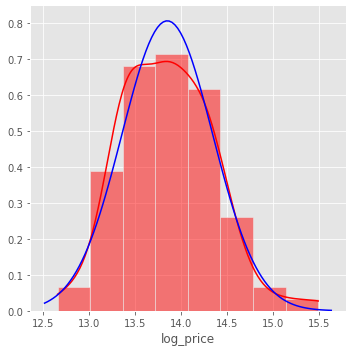

In [41]:
plot = sns.displot(df_zip['log_price'], kde=True, color ="r", stat='density')
plot.map(map_pdf, 'log_price')
print("Skew after Log Transformation: %f" % df_target['log_price'].skew())
print("Kurtosis after Log Transformation: %f" % stats.kurtosis(df_target['log_price'],fisher = False))

Skew after Log Transformation: -0.228680
Kurtosis after Log Transformation: 4.559367


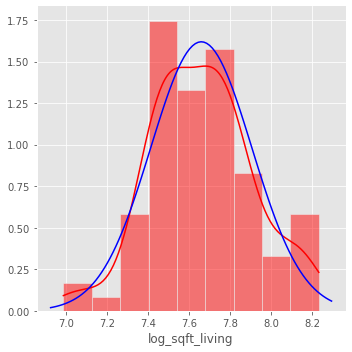

In [42]:
plot = sns.displot(df_zip['log_sqft_living'], kde=True, color ="r", stat='density')
plot.map(map_pdf, 'log_sqft_living')
print("Skew after Log Transformation: %f" % df_target['log_sqft_living'].skew())
print("Kurtosis after Log Transformation: %f" % stats.kurtosis(df_target['log_sqft_living'],fisher = False))

Text(0, 0.5, 'log(Sale Price)')

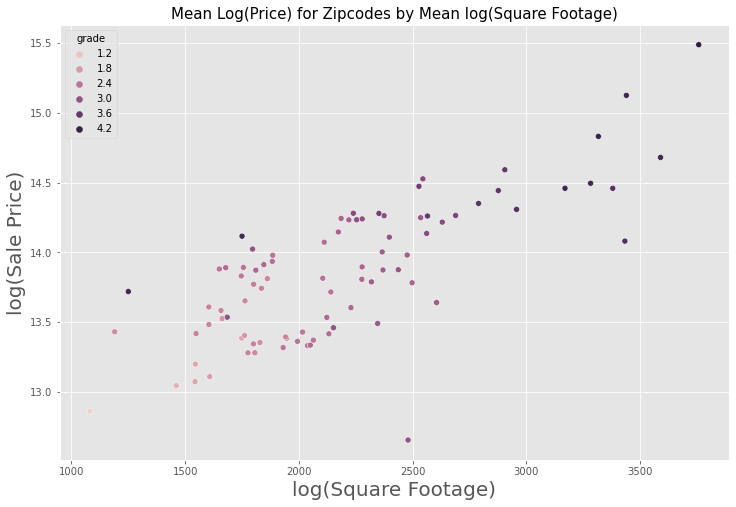

In [43]:
# Set up plot
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.scatterplot(data=df_zip, x='sqft_living', y='price', hue='grade')
# Plot legibility 
plt.title('Mean Price for Zipcodes by Mean Square Footage', size=15)
plt.xlabel('Square Footage', size=20)
plt.ylabel('log(Sale Price)', size=20)


In [44]:
df_zip.describe()

price  sqft_living      grade   bedrooms     floors       view  \
count  8.700000e+01    87.000000  87.000000  87.000000  87.000000  87.000000   
mean   1.178456e+06  2184.829387   2.735899   3.413915   1.592121   0.387977   
std    7.220876e+05   554.761755   0.697794   0.456276   0.315470   0.455613   
min    3.127500e+05  1081.666667   1.000000   2.000000   1.200000   0.000000   
25%    6.792288e+05  1786.250342   2.220392   3.189319   1.399297   0.100147   
50%    1.014905e+06  2122.944282   2.617312   3.472973   1.527027   0.267101   
75%    1.518162e+06  2478.114187   3.123505   3.642331   1.732519   0.511246   
max    5.332431e+06  3758.017241   4.293103   4.666667   3.000000   3.000000   

       sqft_basement  sqft_garage  sqft_patio  waterfront  log_price  \
count      87.000000    87.000000   87.000000   87.000000  87.000000   
mean      492.583379   325.472210  241.376617    0.020483  13.847059   
std       241.057678   177.953490  116.878621    0.042731   0.498240   
min         0.000000     0.000000   20.000000    0.000000  12.653159   
25%       308.675092   155.562640  174.337087    0.000000  13.428713   
50%       461.476684   376.046296  216.447368    0.008772  13.830305   
75%       655.655518   465.435383  265.036754    0.019176  14.233011   
max      1150.000000   700.000000  815.000000    0.266667  15.489318   

       log_sqft_living  
count        87.000000  
mean          7.658726  
std           0.247880  
min           6.986258  
25%           7.487858  
50%           7.660559  
75%           7.815253  
max           8.231647

In [45]:
y_model4 = df_zip['log_price']
X_model4 = df_zip.drop(['price', 'log_price', 'log_sqft_living', 'ZIPCODE', 'sqft_basement',
                        'sqft_garage', 'sqft_patio'], axis=1)
model4 = sm.OLS(y_model4, sm.add_constant(X_model4)).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     33.69
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           5.72e-20
Time:                        17:47:59   Log-Likelihood:                -7.5036
No. Observations:                  87   AIC:                             29.01
Df Residuals:                      80   BIC:                             46.27
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.2195      0.428     30.896      

Result:
- The model explains about 69.5% of the variance in our data.
- The Prob F-statistic is less than alpha of 0.05 and is statistically significant compared to our previous models
- sqft_living is statistically significant with a p-value less than alpha of 0.05
- The ZIPCODE dataset has a high degree of cardinality. A larget dataset may be beneficial for our models performance
- The Condition Number is low showing that there is low signs of multicollinearity in our model compare to our previous models

To interpret the coefficients of variables that are not log transformed we will exponentiate each coefficient value, subtract by 1, and multiply by 100 to find the percentage increase of price. 

Interpretations:
- For each step up in the condition rating, holding all else at 0, the expected price is approximately 41% times higher.
- For each step up in the grade rating, holding all else at 0, the expected price is approximately 57.92% higher.
- For each additional bedroom, holding all else at 0, the expected price is approximately 29.25% lower.
- For each additional floor, , holding all else at 0, the expected price is approximately 10.05% lower.
- For each step up in the view rating, , holding all else at 0, the expected price is approximately 13.71% lower.
- If the house is on the waterfront compared to not being on the watefront, holding all else at 0, the expected price is approximately 175.4% higher.
- For every 1% increase in log_sqft_living, holding all else at 0, the expected price is approximately 1.02% higher.
***

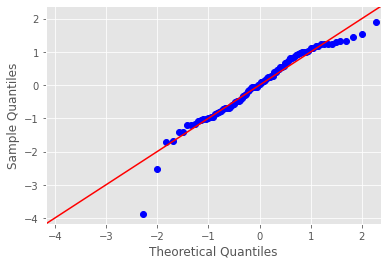

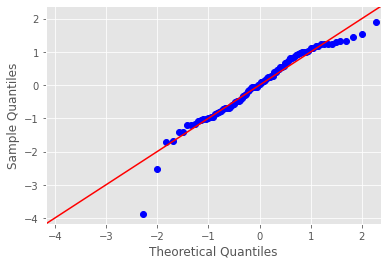

In [46]:
resids = model4.resid
sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)

Looking at the qq-plot of our residuals we can see that our residuals are normally distributed.

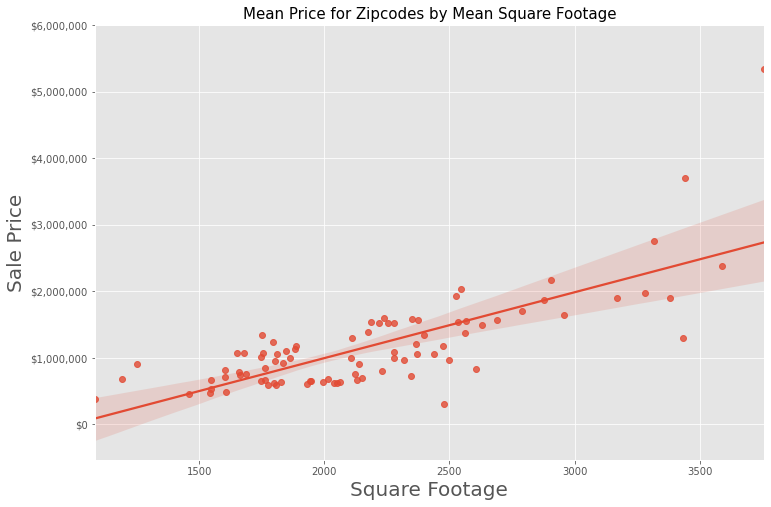

In [47]:
# Set up plot
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.regplot(data=df_zip, x='sqft_living', y='price')
# Plot legibility 
plt.title('Mean Price for Zipcodes by Mean Square Footage', size=15)
plt.xlabel('Square Footage', size=20)
#plt.xscale("log")
plt.ylabel('Sale Price', size=20)
y_ticks = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000]
y_labels = ['$0', '$1,000,000', '$2,000,000', '$3,000,000', '$4,000,000', '$5,000,000', '$6,000,000']
plt.yticks(y_ticks, y_labels, size=10);

#plt.yscale("log")

In [48]:
# Lets take a look at our outlier 
print(df_zip[df_zip['log_price'] < 12.7])
print(df_zip[df_zip['log_price'] > 15.2])

   ZIPCODE     price  sqft_living  grade  bedrooms  floors  view  \
86   98422  312750.0       2480.0    3.0       3.0     2.0   3.0   

    sqft_basement  sqft_garage  sqft_patio  waterfront  log_price  \
86          620.0          0.0       600.0         0.0  12.653159   

    log_sqft_living  
86         7.816014  
   ZIPCODE         price  sqft_living     grade  bedrooms    floors      view  \
24   98039  5.332431e+06  3758.017241  4.293103  3.862069  1.577586  0.965517   

    sqft_basement  sqft_garage  sqft_patio  waterfront  log_price  \
24     842.586207   495.086207  441.206897     0.12069  15.489318   

    log_sqft_living  
24         8.231647  


Our outliers are Medina, WA (98039) and Tacoma, WA (98422). Medina has a very high average home sale price of $5,319,170. Medina has a very high concentration of high networth individuals being home to notable people such as Bill Gates and Jeff Bezos (https://en.wikipedia.org/wiki/Medina,_Washington). On the other end Tacoma has a low average home sale price of 312,750 (https://www.neighborhoodscout.com/wa/tacoma/crime).

In [49]:
# Import Folium 
import folium
# Import json
import json

# Use geopandas to convert shapefile to GeoJSON
shp_file = gpd.read_file('data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp')
shp_file.to_file('data/Zipcodes_for_King_County.geojson', driver='GeoJSON')

# Load GeoJSON
geo_filepath = 'data/Zipcodes_for_King_County.geojson'
with open(geo_filepath, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
temp = geo_data

# create list of only relevent zipcodes
obs_zips = []
for i in range(len(temp['features'])):
    if temp['features'][i]['properties']['ZIPCODE'] in list(df_zip['ZIPCODE']):
        obs_zips.append(temp['features'][i])
        
# create new JSON object for areas
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = obs_zips

# create final file and write data into it
open("data/Clean_King_County_Zipcodes.geojson", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

#geo_file = gpd.sjoin(df_zip, shp_file, how='right', predicate='contains')
#shp_file.to_file('data/Zipcodes_for_King_County.geojson', driver='GeoJSON')

16554805

In [50]:
def create_map(df, column):
    # Reading GeoJSON file
    king_geo = 'data/Clean_King_County_Zipcodes.geojson'
    m = folium.Map(location = [47.57, -121.5], zoom_start=8.5)
    # Create choropleth map
    m.choropleth(
        geo_data = king_geo,
        name='choropleth',
        data = df,
        columns=['ZIPCODE', column],
        fill_color="YlOrRd",
        fill_opacity = 0.9,
        line_opacity = 0.2,
        # refers to which key within GeoJSON to map ZIP code to
        key_on = 'feature.properties.ZIPCODE',
        # First element contains location information, second element contain feature of interest
        legend_name = column.title() + ' ' + ' Across King County'
    )
    folium.LayerControl().add_to(m)
    # Save map with filename based on feature of interest
    return m

In [51]:
create_map(df_zip, 'price')

/Users/kaicansler/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


Text(0, 0.5, 'R-Squared Value')

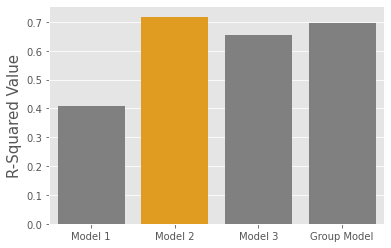

In [52]:
models = ['Model 1', 'Model 2', 'Model 3', 'Group Model']
models_rsquared_adj = np.array([0.410, 0.718, 0.656, 0.695])

not_final_c = ['grey' if (x < max(models_rsquared_adj)) else 'orange' for x in models_rsquared_adj ]
sns.barplot(x=models, y=models_rsquared_adj, palette=not_final_c)
plt.ylabel('R-Squared Value', size=15)

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assuming 'data' is your DataFrame with features and target variable
# and 'target_column' is your target variable column name
#df_target = df_target.drop(['log_price'], axis=1)

# Separate features and target variable
X = df_target.drop(['price'], axis=1)
X = pd.get_dummies(sm.add_constant(X), columns=['ZIPCODE'], drop_first=True)
y = df_target['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions_test = model.predict(X_test)

# Find the MSE of our final model
model_mse = mean_absolute_error(y_test, predictions_test)
print(f"Mean Absolute Error: {model_mse}")

# Make predictions on the entire dataset
predictions = model.predict(X)

# Calculate residuals
residuals = y - predictions

# Filter observations where the observed outcome is below the prediction
below_prediction = df_target[residuals < 0]

# Collect relevant information from these observations
collected_data = below_prediction[df_target.columns]
 
# Display or further analyze the collected data
print(collected_data.sample(n=5, random_state=42))


Mean Absolute Error: 215940.08597170067
           price  sqft_living  sqft_basement  sqft_garage  sqft_patio  \
12637   545000.0         1810              0          700         130   
18980   771500.0         1380            440          210         110   
18164   636200.0         1110              0            0          80   
19643  1800000.0         3090              0          550         230   
28209   980000.0         2510              0          510         860   

       waterfront  grade  floors  bedrooms  view ZIPCODE  
12637           0      2     2.0         3     0   98001  
18980           0      2     2.0         3     0   98105  
18164           0      2     1.0         3     0   98155  
19643           0      4     2.0         5     0   98006  
28209           1      3     2.0         3     4   98042  


### Recommendation

1. We can utilize the model with new listings on the housing market to identify potential investment opportunities. 
2. Some examples are are these properties listed in various ZIP codes. Depending on your capital we can choose options to do further research to pin point opportunities to turn a profit. 
3. ZIP codes is a big factor when it comes to the pricing of the properties. The next feature is square footage of the property.
4. Notably the number of floors as well bedrooms, square footage of garage and patio also have a negative effect of our expected property value. This could be a result of properties near inner cities do not have these options and also have a higher pricing per square footage than properties outside of inner citites that have these options.
5. Linear regression was not the best modeling technicque and further research should be conducted before coming to a conclusion for these properties. 
6. We can vastly cut down on the time it tkaes to look for properties by understanding the expected price based on the model and finding properties that are listed below.